In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy

In [3]:
bs = 32

In [4]:
URLs.CARS

'https://s3.amazonaws.com/fast-ai-imageclas/stanford-cars'

In [5]:
path = untar_data(URLs.CARS) 
path

PosixPath('/home/jupyter/.fastai/data/stanford-cars')

In [6]:
all_images_path = download_data('http://imagenet.stanford.edu/internal/car196/car_ims.tgz', ext='')

In [7]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/stanford-cars/cars_train'),
 PosixPath('/home/jupyter/.fastai/data/stanford-cars/cars_annos.mat'),
 PosixPath('/home/jupyter/.fastai/data/stanford-cars/cars_test'),
 PosixPath('/home/jupyter/.fastai/data/stanford-cars/car_ims'),
 PosixPath('/home/jupyter/.fastai/data/stanford-cars/cars_ims')]

In [8]:
import scipy.io as sio

In [9]:
annotations = sio.loadmat(open(path/'cars_annos.mat', 'rb'))

In [10]:
annotations

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Feb 28 19:34:55 2015',
 '__version__': '1.0',
 '__globals__': [],
 'annotations': array([[(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         (array(['car_ims/000004.jpg'], dtype='<U18'), array([[33]], dtype=uint8), array([[50]], dtype=uint8), array([[197]], dtype=uint8), array([[150]], dtype=uint8), arr

In [11]:
class_names = [cn[0] for cn in annotations['class_names'][0]]

In [12]:
class_names[:5]

['AM General Hummer SUV 2000',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012']

In [13]:
annotations['annotations']

array([[(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
        (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
        (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
        (array(['car_ims/000004.jpg'], dtype='<U18'), array([[33]], dtype=uint8), array([[50]], dtype=uint8), array([[197]], dtype=uint8), array([[150]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
        ...,
        (array(['car_ims/016182.jpg'], dtype='<U18'), array([[29]], dtype=uint8), array([[34]

In [14]:
file_data = [(class_names[int(x[5]) - 1], int(x[6])) for x in annotations['annotations'][0]]

In [15]:
import pandas as pd

file_data_df = pd.DataFrame(file_data, columns=['label', 'istest'])

In [16]:
fnames = get_image_files(path/'car_ims')
fnames.sort()

In [17]:
fnames[0:10]

[PosixPath('/home/jupyter/.fastai/data/stanford-cars/car_ims/000001.jpg'),
 PosixPath('/home/jupyter/.fastai/data/stanford-cars/car_ims/000002.jpg'),
 PosixPath('/home/jupyter/.fastai/data/stanford-cars/car_ims/000003.jpg'),
 PosixPath('/home/jupyter/.fastai/data/stanford-cars/car_ims/000004.jpg'),
 PosixPath('/home/jupyter/.fastai/data/stanford-cars/car_ims/000005.jpg'),
 PosixPath('/home/jupyter/.fastai/data/stanford-cars/car_ims/000006.jpg'),
 PosixPath('/home/jupyter/.fastai/data/stanford-cars/car_ims/000007.jpg'),
 PosixPath('/home/jupyter/.fastai/data/stanford-cars/car_ims/000008.jpg'),
 PosixPath('/home/jupyter/.fastai/data/stanford-cars/car_ims/000009.jpg'),
 PosixPath('/home/jupyter/.fastai/data/stanford-cars/car_ims/000010.jpg')]

In [18]:
file_data_df['name'] = fnames

In [19]:
file_data_df['istest'].value_counts()

0    8144
1    8041
Name: istest, dtype: int64

In [20]:
file_data_df['name'] = file_data_df['name'].apply(lambda x: x.name)

In [21]:
train_df = file_data_df[file_data_df['istest'] == 0][['name', 'label']]
test_df = file_data_df[file_data_df['istest'] == 1][['name', 'label']]

In [22]:
train_df.head()

,name,label
0,000001.jpg,AM General Hummer SUV 2000
1,000002.jpg,AM General Hummer SUV 2000
2,000003.jpg,AM General Hummer SUV 2000
3,000004.jpg,AM General Hummer SUV 2000
4,000005.jpg,AM General Hummer SUV 2000


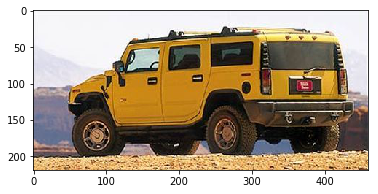

In [248]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(fnames[1])
imgplot = plt.imshow(img)
plt.show()

In [23]:
test_df.head()

,name,label
45,000046.jpg,AM General Hummer SUV 2000
46,000047.jpg,AM General Hummer SUV 2000
47,000048.jpg,AM General Hummer SUV 2000
48,000049.jpg,AM General Hummer SUV 2000
49,000050.jpg,AM General Hummer SUV 2000


In [24]:
data = ImageDataBunch.from_df(path/'car_ims', train_df, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

In [25]:
test_data = ImageList.from_df(test_df, path/'car_ims')

In [26]:
data.add_test(test_data)

In [27]:
data

ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000
Path: /home/jupyter/.fastai/data/stanford-cars/car_ims;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Chevrolet Avalanche Crew Cab 2012,Ford F-150 Regular Cab 2007,Audi TT Hatchback 2011,Ferrari 458 Italia Convertible 2012,MINI Cooper Roadster Convertible 2012
Path: /home/jupyter/.fastai/data/stanford-cars/car_ims;

Test: LabelList (8041 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/jupyter/.fastai/data/stanford-cars/car_ims

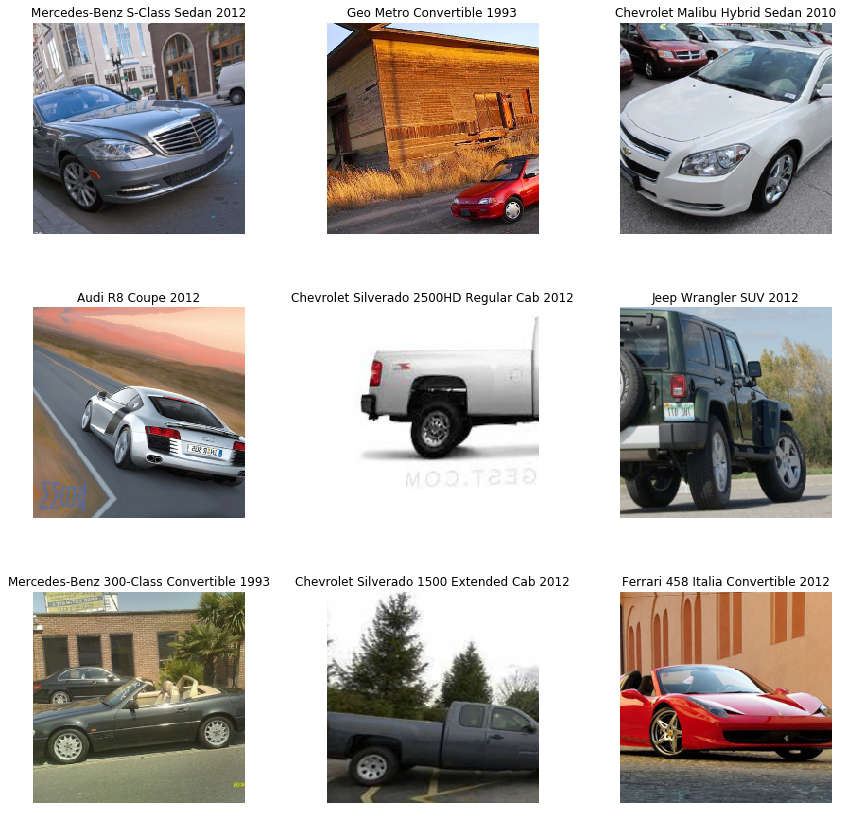

In [282]:
data.show_batch(rows=3)

In [283]:
data

ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000,AM General Hummer SUV 2000
Path: /home/jupyter/.fastai/data/stanford-cars/car_ims;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Spyker C8 Coupe 2009,Hyundai Sonata Sedan 2012,Lamborghini Reventon Coupe 2008,HUMMER H2 SUT Crew Cab 2009,Dodge Ram Pickup 3500 Quad Cab 2009
Path: /home/jupyter/.fastai/data/stanford-cars/car_ims;

Test: LabelList (8041 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/jupyter/.fastai/data/stanford-cars/car_ims

## Prediction

In [284]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])

In [285]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,5.610627,4.936750,0.957002,0.042998,01:04
1,4.589858,3.741867,0.813882,0.186118,01:04
2,3.563505,2.874708,0.687346,0.312654,01:02
3,2.780987,2.400403,0.601966,0.398034,01:03
4,2.355976,2.154798,0.547912,0.452088,01:00
5,1.999366,1.980976,0.512899,0.487101,01:03
6,1.707650,1.870631,0.484644,0.515356,01:03
7,1.529131,1.795863,0.458845,0.541155,01:02
8,1.419923,1.766134,0.455160,0.544840,01:02
9,1.327137,1.757025,0.449631,0.550369,01:01


In [286]:
learn.save('cars-stage-1')

In [303]:
test_predictions = learn.predict(test_data[0])

In [311]:
test_predictions = []
for test_image in test_data:
    test_predictions.append(learn.predict(test_image)[0])
    if len(test_predictions) % 300 == 0:
        print(len(test_predictions))

300
600
900
1200
1500
1800
2100
2400
2700
3000
3300
3600
3900
4200
4500
4800
5100
5400
5700
6000
6300
6600
6900
7200
7500
7800


In [315]:
len(test_predictions)

8041

In [316]:
test_df['predictions'] = test_predictions

In [317]:
test_df.head()

,name,label,predictions
45,000046.jpg,AM General Hummer SUV 2000,AM General Hummer SUV 2000
46,000047.jpg,AM General Hummer SUV 2000,AM General Hummer SUV 2000
47,000048.jpg,AM General Hummer SUV 2000,AM General Hummer SUV 2000
48,000049.jpg,AM General Hummer SUV 2000,HUMMER H2 SUT Crew Cab 2009
49,000050.jpg,AM General Hummer SUV 2000,AM General Hummer SUV 2000


In [324]:
test_df['predictions'] = test_df['predictions'].apply(str)

In [326]:
(test_df['label'] == test_df['predictions']).sum()/test_df.shape[0]

0.5580151722422584

## Results


In [327]:
interp = ClassificationInterpretation.from_learner(learn)

In [211]:
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

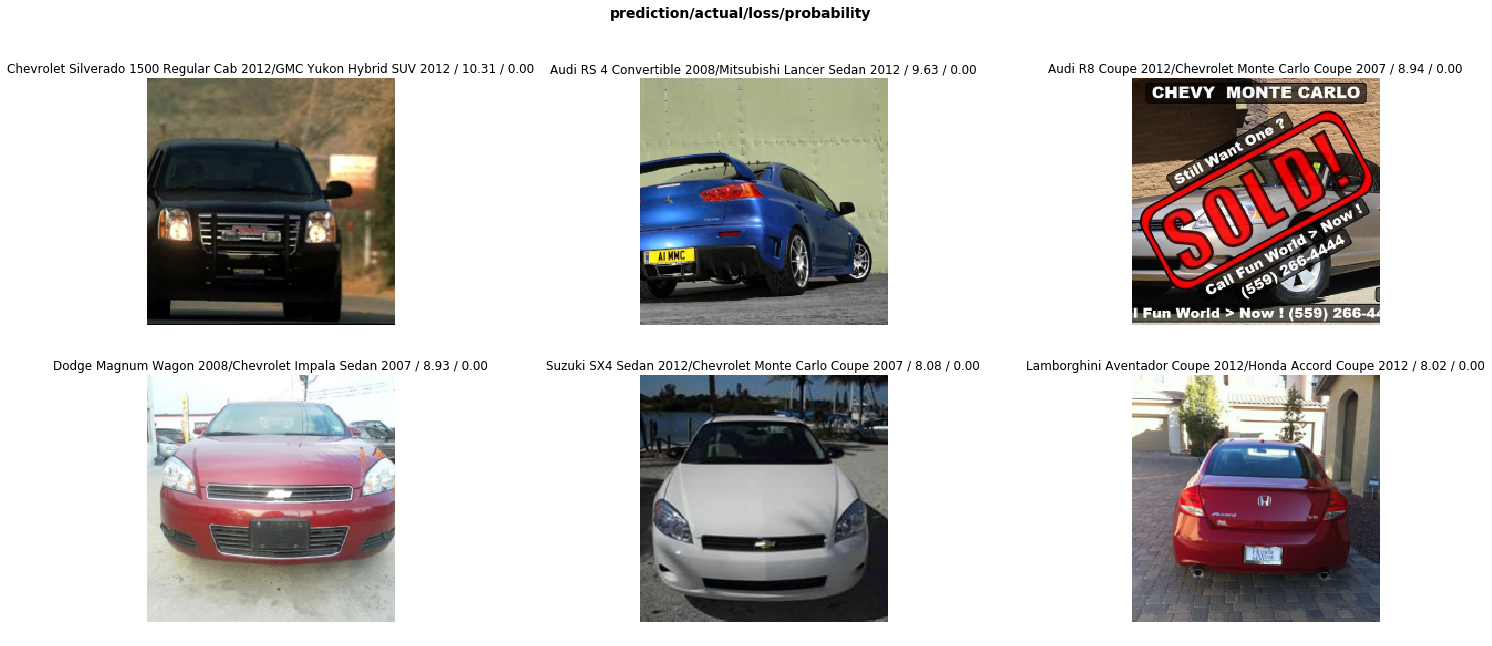

In [212]:
interp.plot_top_losses(6, figsize=(25, 10), heatmap=False)

In [213]:
interp.most_confused(min_val=5)

[('Audi TTS Coupe 2012', 'Audi TT Hatchback 2011', 7),
 ('Chevrolet Silverado 1500 Hybrid Crew Cab 2012',
  'Chevrolet Silverado 1500 Extended Cab 2012',
  7),
 ('Chevrolet Express Cargo Van 2007', 'Chevrolet Express Van 2007', 6),
 ('Audi A5 Coupe 2012', 'Audi S5 Coupe 2012', 5),
 ('Chevrolet Express Van 2007', 'Chevrolet Express Cargo Van 2007', 5),
 ('Ferrari 458 Italia Convertible 2012', 'Ferrari 458 Italia Coupe 2012', 5),
 ('Jeep Liberty SUV 2012', 'Jeep Patriot SUV 2012', 5),
 ('Spyker C8 Coupe 2009', 'Spyker C8 Convertible 2009', 5)]

## Unfreeze, train the full model

In [328]:
learn.unfreeze()

In [329]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


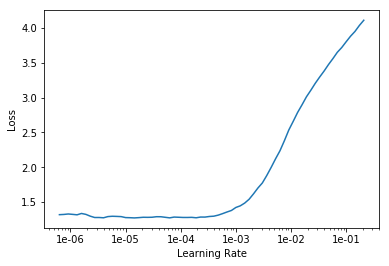

In [330]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-4))

In [334]:
learn.save('cars-stage-1-unfreeze')

In [335]:
test_df.to_csv('cars-stage-1.csv')

## Resnet50

In [28]:
learn50 = cnn_learner(data, models.resnet50, metrics=[error_rate, accuracy])

In [29]:
learn50.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,5.009271,4.263097,0.867322,0.132678,01:24
1,3.772571,3.190387,0.725430,0.274570,01:16
2,2.922014,2.437084,0.613636,0.386364,01:15
3,2.369326,1.980837,0.520270,0.479730,01:15
4,1.908650,1.754083,0.463145,0.536855,01:15
5,1.550115,1.536081,0.410934,0.589066,01:15
6,1.238951,1.432851,0.378993,0.621007,01:15
7,1.020568,1.374044,0.355651,0.644349,01:15
8,0.858744,1.332445,0.344595,0.655405,01:16
9,0.806492,1.316713,0.336609,0.663391,01:16


In [30]:
learn50.save('cars-resnet50-1')

In [31]:
interp = ClassificationInterpretation.from_learner(learn50)

In [32]:
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

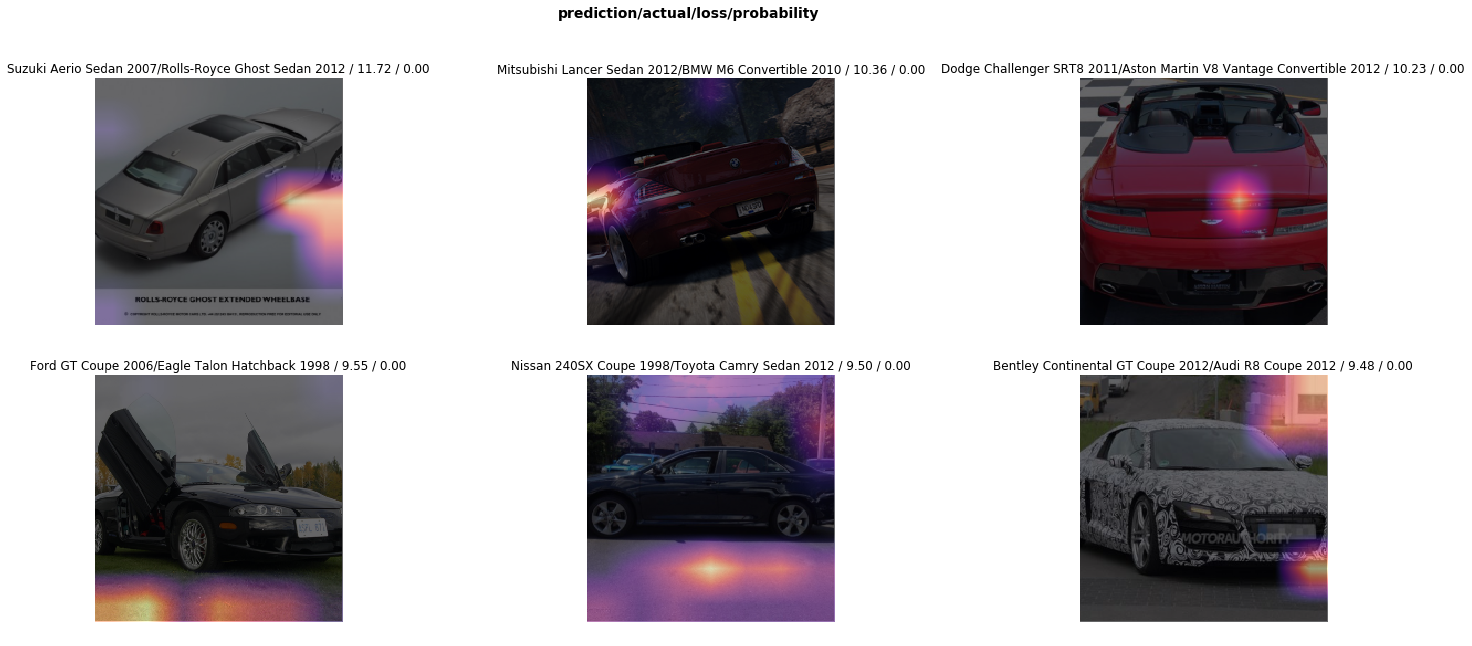

In [33]:
interp.plot_top_losses(6, figsize=(25, 10), heatmap=True)

In [34]:
interp.most_confused(min_val=2)

[('Audi 100 Wagon 1994', 'Audi 100 Sedan 1994', 5),
 ('BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 4),
 ('Land Rover LR2 SUV 2012', 'Land Rover Range Rover SUV 2012', 4),
 ('Acura TSX Sedan 2012', 'Acura TL Sedan 2012', 3),
 ('Audi TT Hatchback 2011', 'Audi TTS Coupe 2012', 3),
 ('Audi TTS Coupe 2012', 'Audi TT Hatchback 2011', 3),
 ('Audi V8 Sedan 1994', 'Audi 100 Sedan 1994', 3),
 ('BMW Z4 Convertible 2012', 'BMW M6 Convertible 2010', 3),
 ('Chevrolet Camaro Convertible 2012', 'Ford Mustang Convertible 2007', 3),
 ('Chevrolet Corvette ZR1 2012', 'Chevrolet Corvette Convertible 2012', 3),
 ('Chevrolet Express Van 2007', 'GMC Savana Van 2012', 3),
 ('Chevrolet Monte Carlo Coupe 2007', 'Chevrolet Impala Sedan 2007', 3),
 ('Chevrolet Silverado 2500HD Regular Cab 2012',
  'Chevrolet Silverado 1500 Regular Cab 2012',
  3),
 ('GMC Savana Van 2012', 'Chevrolet Express Cargo Van 2007', 3),
 ('Hyundai Sonata Sedan 2012', 'Hyundai Azera Sedan 2012', 3),
 ('Spyker C8 Convertible 2009', 'Spyker C8 C

In [35]:
test_predictions = []
for test_image in test_data:
    test_predictions.append(learn50.predict(test_image)[0])
    if len(test_predictions) % 300 == 0:
        print(len(test_predictions))

300
600
900
1200
1500
1800
2100
2400
2700
3000
3300
3600
3900
4200
4500
4800
5100
5400
5700
6000
6300
6600
6900
7200
7500
7800


In [37]:
test_df = pd.read_csv('cars-stage-1.csv')

In [38]:
test_df['predictions'] = test_predictions
test_df['predictions'] = test_df['predictions'].apply(str)
(test_df['label'] == test_df['predictions']).sum()/test_df.shape[0]

0.6645939559756249

In [39]:
test_df.to_csv('cars-stage-1.csv')

In [40]:
learn50.unfreeze()
learn50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


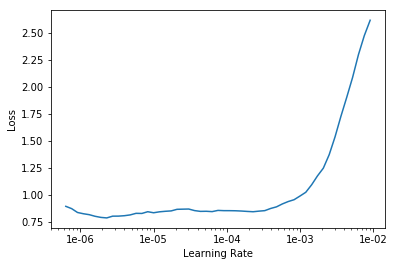

In [41]:
learn50.recorder.plot()

In [43]:
learn50.unfreeze()
learn50.fit_one_cycle(5, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.817958,1.294190,0.334767,0.665233,01:34
1,0.768263,1.223206,0.321867,0.678133,01:35
2,0.700051,1.168160,0.308354,0.691646,01:35
3,0.655736,1.144811,0.300983,0.699017,01:35
4,0.623149,1.143479,0.301597,0.698403,01:35


In [44]:
test_predictions = []
for test_image in test_data:
    test_predictions.append(learn50.predict(test_image)[0])
    if len(test_predictions) % 300 == 0:
        print(len(test_predictions))

300
600
900
1200
1500
1800
2100
2400
2700
3000
3300
3600
3900
4200
4500
4800
5100
5400
5700
6000
6300
6600
6900
7200
7500
7800


In [46]:
test_df['rn50-predictions'] = test_predictions
test_df['rn50-predictions'] = test_df['rn50-predictions'].apply(str)
(test_df['label'] == test_df['rn50-predictions']).sum()/test_df.shape[0]

0.7078721552045766